In [1]:
import sys
import numpy as np
import rasterio
from matplotlib import pyplot as pt
import torch as T
import util
from clustering import *

device = T.device('cuda:1') # but it can also run on cpu
    

In [2]:
# load the data

tilename = 'data/3807602_se'

x1 = rasterio.open(tilename + '_2013.tif').read() / 255.
x2 = rasterio.open(tilename + '_2017.tif').read() / 255.
nlcd = rasterio.open(tilename + '_nlcd.tif').read()[0,::4,::4]
buildings = 1 - rasterio.open(tilename + '_buildings.tif').read()[0,::4,::4]

#blur the road map

roads = rasterio.open(tilename + '_roads.tif').read().astype(np.float32)
roads += bag(T.from_numpy(roads),2).numpy()
roads[roads>0] = 1.
roads += bag(T.from_numpy(roads),2).numpy()
roads = roads[0,::4,::4]

/data/anaconda/lib/python3.8/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


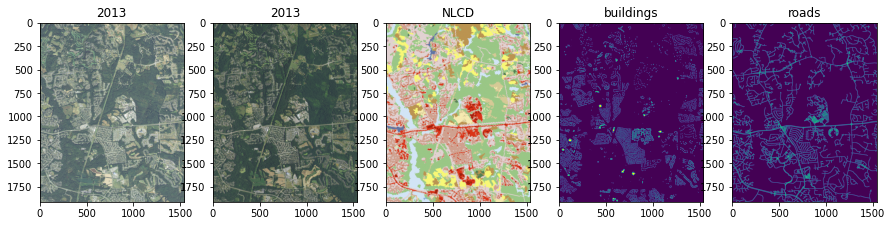

In [3]:
# show the data

pt.figure(figsize=(15,10))

pt.subplot(151)
pt.title('2013')
pt.imshow(x1[:3].T.swapaxes(0,1))

pt.subplot(152)
pt.title('2013')
pt.imshow(x2[:3].T.swapaxes(0,1))

pt.subplot(153)
pt.title('NLCD')
pt.imshow(util.vis_nlcd(nlcd, True).T.swapaxes(0,1))

pt.subplot(154)
pt.title('buildings')
pt.imshow(buildings)

pt.subplot(155)
pt.title('roads')
pt.imshow(roads)

pt.show()

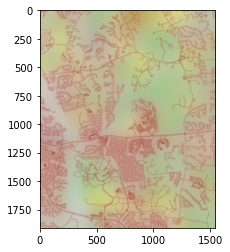

In [4]:
# build the prior
# it is approximately a Gaussian blur of the NLCD
# urban classes are treated differently: we allow only High Intensity and Open Space
# (after neural smoothing) we can replace Open Space with the second most likely class

w,h = nlcd.shape

prior = np.zeros((len(util.nlcd_cl),w,h))
for i in range(len(util.nlcd_cl)):
    prior[i] = (nlcd == util.nlcd_cl[i])
pic = T.tensor(prior, device=device).float()

pc = pic.sum((1,2))
pc[3:7] = pc[3:7].sum()

pic += 0.01

pic /= pic.sum(0)
for _ in range(8):
    pic = bag(pic,40) + 0.000001
pic /= pic.sum(0)

built = T.tensor(np.maximum(roads,buildings),device=device).float()
built[built>1]=1

pic[6] += bag(built,10) * 0.3
pic[6] += 0.01
purban = (0.7*pic[6] + 0.5*pic[5] + 0.3*pic[4] + 0.1*pic[3])
pic[3] = (0.3*pic[6] + 0.5*pic[5] + 0.7*pic[4] + 0.9*pic[3])
pic[6] = purban
pic[4:6] = 0.
pic[6] += built

pic[pc==0] = 0.

pic /= pic.sum(0)

del built,purban

pt.imshow(util.vis_nlcd(pic.cpu().numpy()).T.swapaxes(0,1))
pt.show()


In [6]:
# set up

window = 2
scale = (2*window+1)**2  

nc = 22
nb = 32
ns = 32

data1 = T.tensor(x1, device=device).float()
data2 = T.tensor(x2, device=device).float()

qic1 = T.rand((nc,w,h), device=device).float()
qib1 = T.rand((nb,w,h), device=device).float()
qis1 = T.rand((ns,w,h), device=device).float()
pcs1 = T.ones((nc,ns), device=device).float()

qic2 = T.rand((nc,w,h), device=device).float()
qib2 = T.rand((nb,w,h), device=device).float()
qis2 = T.rand((ns,w,h), device=device).float()
pcs2 = T.ones((nc,ns), device=device).float()

pcc = T.ones((nc,nc), device=device).float()

# we set the diagonal to be 5x the rest of the entries
for i in range(nc): pcc[i,i] += 4  
    


0


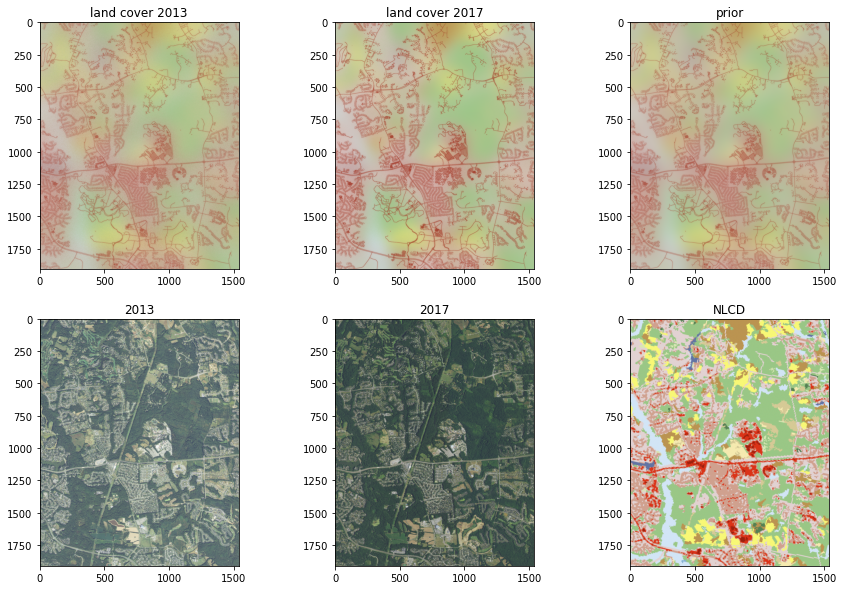

1
2
3
4
5
6
7
8
9
10


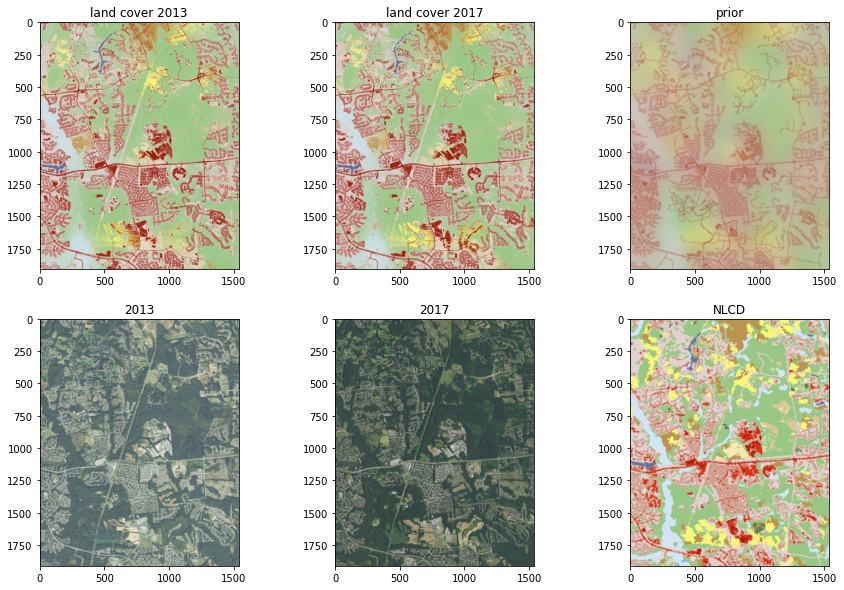

11
12
13
14
15
16
17
18
19
20


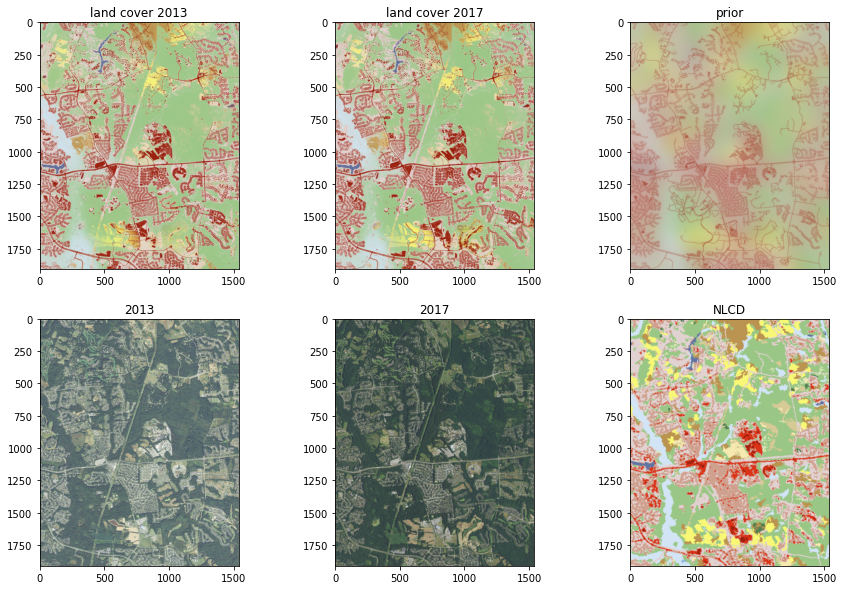

21
22
23
24
25
26
27
28
29
30


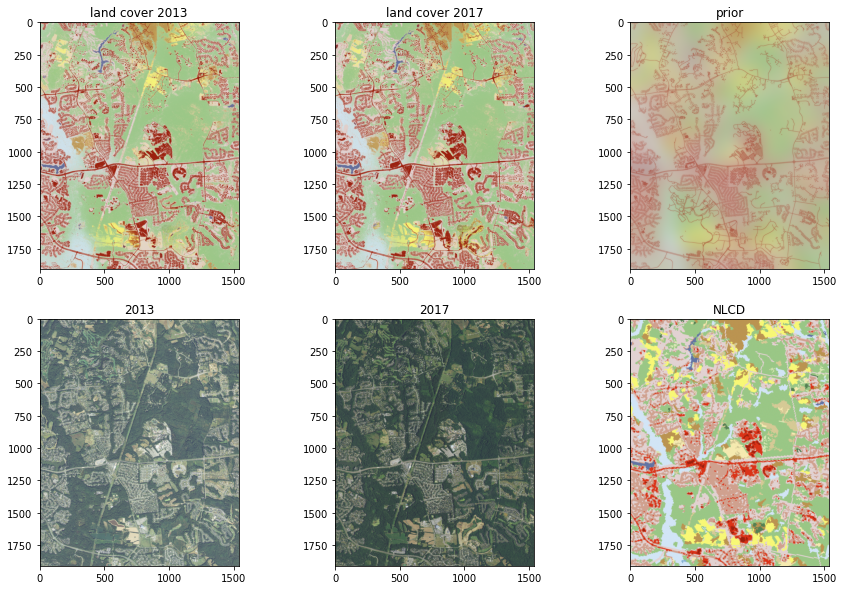

In [7]:
# variational inference

n_iter = 31
show_every = 10

for it in range(n_iter):

    print(it)

    pb1, psb1, qib1, pb2, psb2, qib2, pbc1, pbc2 = update_b_pair(qis1, qib1, qis2, qib2, qic1, qic2, 5, it<3, it<3, True, window, scale)

    qis1, pcs1 = update_s(data1, qis1, pcs1, qic1, psb1, qib1, 5, it<2, True, window, scale)

    qic1 = update_c(pcs1, qis1, pic, qib1, pbc1, True, window)
    qic1 *= (T.einsum('to,oxy->txy', T.log(pcc), qic2)).softmax(0)
    qic1 /= qic1.sum(0)
    qic1+=0.000001

    qis2, pcs2 = update_s(data2, qis2, pcs2, qic2, psb2, qib2, 5, it<2, True, window, scale)

    qic2 = update_c(pcs2, qis2, pic, qib2, pbc2, True, window)
    qic2 *= (T.einsum('to,oxy->txy', T.log(pcc), qic1)).softmax(0)
    qic2 /= qic2.sum(0)
    qic2+=0.000001

    if it%show_every == 0:
        pt.figure(figsize=(15,10))
        pt.subplot(231)
        pt.title('land cover 2013')
        pt.imshow(util.vis_nlcd(qic1.cpu().numpy()).T.swapaxes(0,1))
        pt.subplot(232)
        pt.title('land cover 2017')
        pt.imshow(util.vis_nlcd(qic2.cpu().numpy()).T.swapaxes(0,1))
        pt.subplot(233)
        pt.title('prior')
        pt.imshow(util.vis_nlcd(pic.cpu().numpy()).T.swapaxes(0,1))
        pt.subplot(234)
        pt.title('2013')
        pt.imshow(x1[:3].T.swapaxes(0,1))
        pt.subplot(235)
        pt.title('2017')
        pt.imshow(x2[:3].T.swapaxes(0,1))
        pt.subplot(236)
        pt.title('NLCD')
        pt.imshow(util.vis_nlcd(nlcd,sparse=True).T.swapaxes(0,1))
        pt.show()




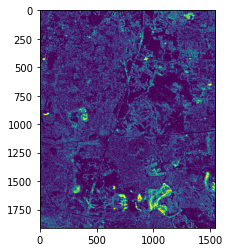

In [8]:
# show the change

pt.imshow((qic1.argmax(0)!=qic2.argmax(0)).cpu().numpy())
pt.show()